In [1]:
using FFTW, LinearAlgebra
using Plots
pyplot()

┌ Info: Recompiling stale cache file /Users/navaro/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


Plots.PyPlotBackend()

In [2]:
using MicroMacro

  8.989506 seconds (14.70 M allocations: 790.234 MiB, 5.41% gc time)
1.1675148665319044e-7


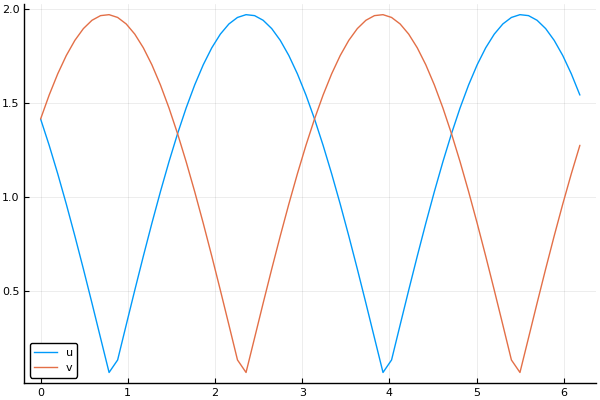

In [3]:
xmin     = 0
xmax     = 2π
T        = 2π
nx       = 64
ntau     = 32
tfinal   = 0.25
epsilon  = 0.1

data = CosSin(xmin, xmax, nx, epsilon, T, tfinal)

dt = 2.0^(-3) * tfinal / 16

m = MicMac(data, ntau)

@time u, v = solve(m, dt)

println(compute_error(u, v, data))

plot(data.x, abs.(u), label=:u)
plot!(data.x, abs.(v), label=:v)

 nx                 : 64 
 ntau               : 64 







Elapsed time :26.311616049


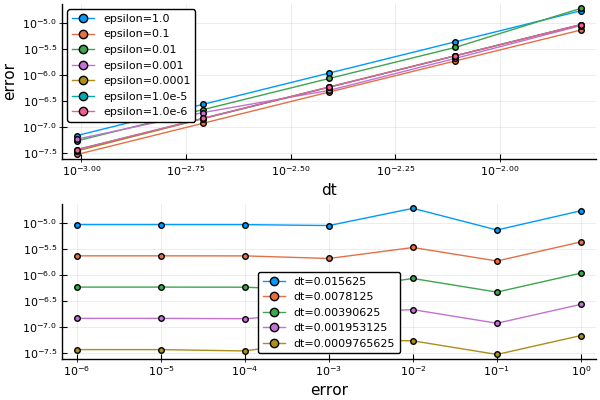

In [4]:
const epsilons = [10.0^(-i) for i in 0:6]
const size_x   = [64]
const size_tau = [64]
const Tfinal   = 0.25
const nb_dt    = 5 # different values of dt

tabdt  = zeros(Float64, nb_dt)
taberr = zeros(Float64, (length(epsilons), nb_dt))

etime = @elapsed for nx in size_x, ntau in size_tau

    println(" nx                 : $nx ")
    println(" ntau               : $ntau ")

    for (kk, epsilon) in enumerate(epsilons)
        
        data = CosSin(xmin, xmax, nx, epsilon, T, Tfinal)

        for hh in 0:nb_dt-1

            dtmicmac = 2.0^(-hh) * data.Tfinal / 16

            solver = MicMac(data, ntau)

            u, v = solve(solver, dtmicmac)

            tabdt[hh+1] = dtmicmac

            err = compute_error(u, v, data)
            taberr[kk,hh+1] = err

        end

    end

end

println("Elapsed time :", etime)

p = plot(layout=(2,1))
xlabel!(p[1,1],"dt")
ylabel!(p[1,1],"error")

for j in 1:size(taberr)[1]
    plot!(p[1,1], 
          tabdt, taberr[j, :], 
          markershape=:circle,
          xaxis=:log,
          yaxis=:log, 
          label="epsilon=$(epsilons[j])")
end

for j in 1:size(taberr)[2]
    plot!(p[2,1], 
          epsilons, taberr[:, j], 
          markershape=:circle,
          xaxis=:log, 
          yaxis=:log, 
          label="dt=$(tabdt[j])")
end

xlabel!(p[2,1],"epsilon")
xlabel!(p[2,1],"error")


p
